In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import pandas as pd

In [56]:
EDGE_FILE = "data/hep-th.net"
NAMES_FILE = "data/hep-th_names.txt"

In [61]:
G_real = nx.read_edgelist(EDGE_FILE, nodetype=int)
node_names = {}
with open(NAMES_FILE, "r") as f:
    for line in f:
        node, name = line.strip().split(" ", 1)
        node_names[int(node)] = name
nx.set_node_attributes(G_coauth, node_names, "name")

print(f"Number of nodes: {G_real.number_of_nodes()}")
print(f"Number of edges: {G_real.number_of_edges()}")
degrees = np.array([d for _, d in G_real.degree()])

Number of nodes: 7610
Number of edges: 15751


In [78]:
def basic_metrics(G, degrees):
    return {
        "N": G.number_of_nodes(),
        "E": G.number_of_edges(),
        "avg_degree": degrees.mean(),
        "degree_std": degrees.std(),
        "max_degree": degrees.max()
    }

def clustering_metrics(G):
    clustering_vals = list(nx.clustering(G).values())
    
    return {
        "avg_clustering": np.mean(clustering_vals),
        "clustering_std": np.std(clustering_vals)
    }

def component_metrics(G):
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    sizes = [len(c) for c in components]
    
    return {
        "num_components": len(components),
        "largest_cc_ratio": sizes[0] / G.number_of_nodes(),
        "second_cc_ratio": sizes[1] / G.number_of_nodes() if len(sizes) > 1 else 0
    }

def path_metrics(G):
    gcc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    
    return {
        "avg_shortest_path": nx.average_shortest_path_length(gcc),
        "diameter": nx.diameter(gcc)
    }

def assortativity_metrics(G):
    return {
        "degree_assortativity": nx.degree_assortativity_coefficient(G)
    }

def transitivity_metric(G):
    return {
        "transitivity": nx.transitivity(G)
    }

def centralization_metrics(G, degrees):
    n = G.number_of_nodes()
    max_k = degrees.max()
    
    centralization = sum(max_k - degrees) / ((n - 1) * (n - 2))
    
    return {
        "degree_centralization": centralization
    }

def macro_metrics(G):
    degrees = np.array([d for _, d in G.degree()])
    
    metrics = {}
    metrics.update(basic_metrics(G, degrees))
    metrics.update(clustering_metrics(G))
    metrics.update(component_metrics(G))
    metrics.update(path_metrics(G))
    metrics.update(assortativity_metrics(G))
    metrics.update(transitivity_metric(G))
    metrics.update(centralization_metrics(G, degrees))
    
    return metrics

In [86]:
real_metrics = macro_metrics(G_real)

In [99]:
real_metrics

{'N': 7610,
 'E': 15751,
 'avg_degree': 4.139553219448095,
 'degree_std': 4.338862590392893,
 'max_degree': 50,
 'avg_clustering': 0.48558011831500486,
 'clustering_std': 0.4190121186788277,
 'num_components': 581,
 'largest_cc_ratio': 0.7667542706964521,
 'second_cc_ratio': 0.0031537450722733244,
 'avg_shortest_path': 7.026387935392767,
 'diameter': 19,
 'degree_assortativity': 0.2939308235264939,
 'transitivity': 0.32957558038700724,
 'degree_centralization': 0.006028716339704531}

In [90]:
def generate_ba_and_metrics(n, m):
    G = nx.barabasi_albert_graph(n, m)
    metrics = macro_metrics(G)
    return metrics

def ba_score_normalized(real, ba, weights=[0.5, 0.3, 0.2]):
    w1, w2, w3 = weights
    
    c_diff = abs(real["avg_clustering"] - ba["avg_clustering"]) / (real["avg_clustering"]+1e-6)
    r_diff = abs(real["degree_assortativity"] - ba["degree_assortativity"]) / (abs(real["degree_assortativity"])+1e-6)
    cent_diff = abs(real["degree_centralization"] - ba["degree_centralization"]) / (real["degree_centralization"]+1e-6)
    
    score = w1*c_diff + w2*r_diff + w3*cent_diff
    return score

In [91]:
ba_results = []

n = real_metrics["N"]

for m in range(1, 7):
    ba_m = generate_ba_and_metrics(n, m)
    score = ba_score(real_metrics, ba_m)
    
    ba_results.append({
        "m": m,
        "avg_degree": ba_m["avg_degree"],
        "avg_clustering": ba_m["avg_clustering"],
        "assortativity": ba_m["degree_assortativity"],
        "centralization": ba_m["degree_centralization"],
        "score": score
    })

ba_results

{'N': 7610, 'E': 15751, 'avg_degree': 4.139553219448095, 'degree_std': 4.338862590392893, 'max_degree': 50, 'avg_clustering': 0.48558011831500486, 'clustering_std': 0.4190121186788277, 'num_components': 581, 'largest_cc_ratio': 0.7667542706964521, 'second_cc_ratio': 0.0031537450722733244, 'avg_shortest_path': 7.026387935392767, 'diameter': 19, 'degree_assortativity': 0.2939308235264939, 'transitivity': 0.32957558038700724, 'degree_centralization': 0.006028716339704531}
{'N': 7610, 'E': 15751, 'avg_degree': 4.139553219448095, 'degree_std': 4.338862590392893, 'max_degree': 50, 'avg_clustering': 0.48558011831500486, 'clustering_std': 0.4190121186788277, 'num_components': 581, 'largest_cc_ratio': 0.7667542706964521, 'second_cc_ratio': 0.0031537450722733244, 'avg_shortest_path': 7.026387935392767, 'diameter': 19, 'degree_assortativity': 0.2939308235264939, 'transitivity': 0.32957558038700724, 'degree_centralization': 0.006028716339704531}
{'N': 7610, 'E': 15751, 'avg_degree': 4.139553219448

[{'m': 1,
  'avg_degree': 1.9997371879106438,
  'avg_clustering': 0.0,
  'assortativity': -0.04461949122337175,
  'centralization': 0.03378470539411862,
  'score': 0.8518864221192846},
 {'m': 2,
  'avg_degree': 3.9989487516425757,
  'avg_clustering': 0.008082698613298654,
  'assortativity': -0.04393342854568544,
  'centralization': 0.040094786474426554,
  'score': 0.8494277419086077},
 {'m': 3,
  'avg_degree': 5.997634691195795,
  'avg_clustering': 0.006957197368197167,
  'assortativity': -0.03823310611714318,
  'centralization': 0.03996350135479334,
  'score': 0.8447216356055336},
 {'m': 4,
  'avg_degree': 7.995795006570302,
  'avg_clustering': 0.007218881435010351,
  'assortativity': -0.034916089146493794,
  'centralization': 0.034968344393759176,
  'score': 0.8361477776070367},
 {'m': 5,
  'avg_degree': 9.993429697766096,
  'avg_clustering': 0.008848395109984539,
  'assortativity': -0.029928069141857565,
  'centralization': 0.04877173096942729,
  'score': 0.8433336305030945},
 {'m':

In [93]:
df_ba = pd.DataFrame(ba_results)
df_ba

,m,avg_degree,avg_clustering,assortativity,centralization,score
0,1,1.999737,0.000000,-0.044619,0.033785,0.851886
1,2,3.998949,0.008083,-0.043933,0.040095,0.849428
2,3,5.997635,0.006957,-0.038233,0.039964,0.844722
3,4,7.995795,0.007219,-0.034916,0.034968,0.836148
4,5,9.993430,0.008848,-0.029928,0.048772,0.843334
5,6,11.990539,0.010466,-0.029502,0.055739,0.848258


In [96]:
print("Real metrics columns:", real_df.columns.tolist())
print("BA metrics columns:", ba_df.columns.tolist())


Real metrics columns: ['N', 'E', 'avg_degree', 'degree_std', 'max_degree', 'avg_clustering', 'clustering_std', 'num_components', 'largest_cc_ratio', 'second_cc_ratio', 'avg_shortest_path', 'diameter', 'degree_assortativity', 'transitivity', 'degree_centralization', 'network']
BA metrics columns: ['m', 'avg_degree', 'avg_clustering', 'assortativity', 'centralization', 'score', 'network']


In [98]:
real_df = pd.DataFrame([real_metrics])
real_df["network"] = "Real"

best_ba = df_ba.loc[df_ba["score"].idxmin()]
ba_df = pd.DataFrame([best_ba])
ba_df["network"] = "BA"

ba_df = ba_df.rename(columns={
    "assortativity": "degree_assortativity",
    "centralization": "degree_centralization"
})

if "avg_shortest_path" not in ba_df.columns:
    ba_df["avg_shortest_path"] = np.nan

cols = ["network", "avg_degree", "avg_clustering", "degree_assortativity", "degree_centralization", "avg_shortest_path"]
comparison_df = pd.concat([real_df[cols], ba_df[cols]], ignore_index=True)
comparison_df

,network,avg_degree,avg_clustering,degree_assortativity,degree_centralization,avg_shortest_path
0,Real,4.139553,0.485580,0.293931,0.006029,7.026388
1,BA,7.995795,0.007219,-0.034916,0.034968,NaN


In [103]:
def score_model(real, model):
    score = 0
    keys = ["avg_degree","avg_clustering","degree_assortativity","degree_centralization","avg_shortest_path"]
    for k in keys:
        score += abs(real[k]-model[k])/(abs(real[k])+1e-6)
    return score

n = G_real.number_of_nodes()
real_metrics = macro_metrics(G_real)
real_metrics["network"] = "Real"

ba_results = []
for m in range(1, 7):
    G_ba = nx.barabasi_albert_graph(n, m, seed=42)
    metrics_ba = macro_metrics(G_ba)
    metrics_ba["m"] = m
    metrics_ba["score"] = score_model(real_metrics, metrics_ba)
    ba_results.append(metrics_ba)
best_ba = pd.DataFrame(ba_results).loc[pd.DataFrame(ba_results)["score"].idxmin()]
best_ba["network"] = "BA"

ws_results = []
for k in range(2, int(round(real_metrics["avg_degree"]*2))):
    for beta in [0.05, 0.1, 0.2, 0.3]:
        G_ws = nx.watts_strogatz_graph(n, k, beta, seed=42)
        metrics_ws = macro_metrics(G_ws)
        metrics_ws["k"] = k
        metrics_ws["beta"] = beta
        metrics_ws["score"] = score_model(real_metrics, metrics_ws)
        ws_results.append(metrics_ws)
best_ws = pd.DataFrame(ws_results).loc[pd.DataFrame(ws_results)["score"].idxmin()]
best_ws["network"] = "WS"

hk_results = []
for m_hk in range(1, 7):
    for p_tri in [0.3,0.5,0.7]:
        G_hk = nx.powerlaw_cluster_graph(n, m_hk, p_tri, seed=42)
        metrics_hk = macro_metrics(G_hk)
        metrics_hk["m_hk"] = m_hk
        metrics_hk["p_tri"] = p_tri
        metrics_hk["score"] = score_model(real_metrics, metrics_hk)
        hk_results.append(metrics_hk)
best_hk = pd.DataFrame(hk_results).loc[pd.DataFrame(hk_results)["score"].idxmin()]
best_hk["network"] = "Holme-Kim"

comparison_df = pd.DataFrame([real_metrics, best_ba, best_ws, best_hk])
comparison_df = comparison_df[["network","N","E","avg_degree","avg_clustering","degree_assortativity","degree_centralization","avg_shortest_path"]]
comparison_df

,network,N,E,avg_degree,avg_clustering,degree_assortativity,degree_centralization,avg_shortest_path
0,Real,7610.0,15751.0,4.139553,0.485580,0.293931,0.006029,7.026388
1,BA,7610.0,15216.0,3.998949,0.005477,-0.039271,0.031813,4.914311
2,WS,7610.0,22830.0,6.000000,0.443281,-0.023286,0.000657,8.318344
3,Holme-Kim,7610.0,15216.0,3.998949,0.517052,-0.069442,0.026160,5.428757


/var/folders/5f/w7s_j_l53rl1c82ffc5ww_200000gn/T/ipykernel_63870/2510457640.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="network", y=metric, data=comparison_df, ax=axes[i], palette="Set2")
/var/folders/5f/w7s_j_l53rl1c82ffc5ww_200000gn/T/ipykernel_63870/2510457640.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="network", y=metric, data=comparison_df, ax=axes[i], palette="Set2")
/var/folders/5f/w7s_j_l53rl1c82ffc5ww_200000gn/T/ipykernel_63870/2510457640.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="network", y=met

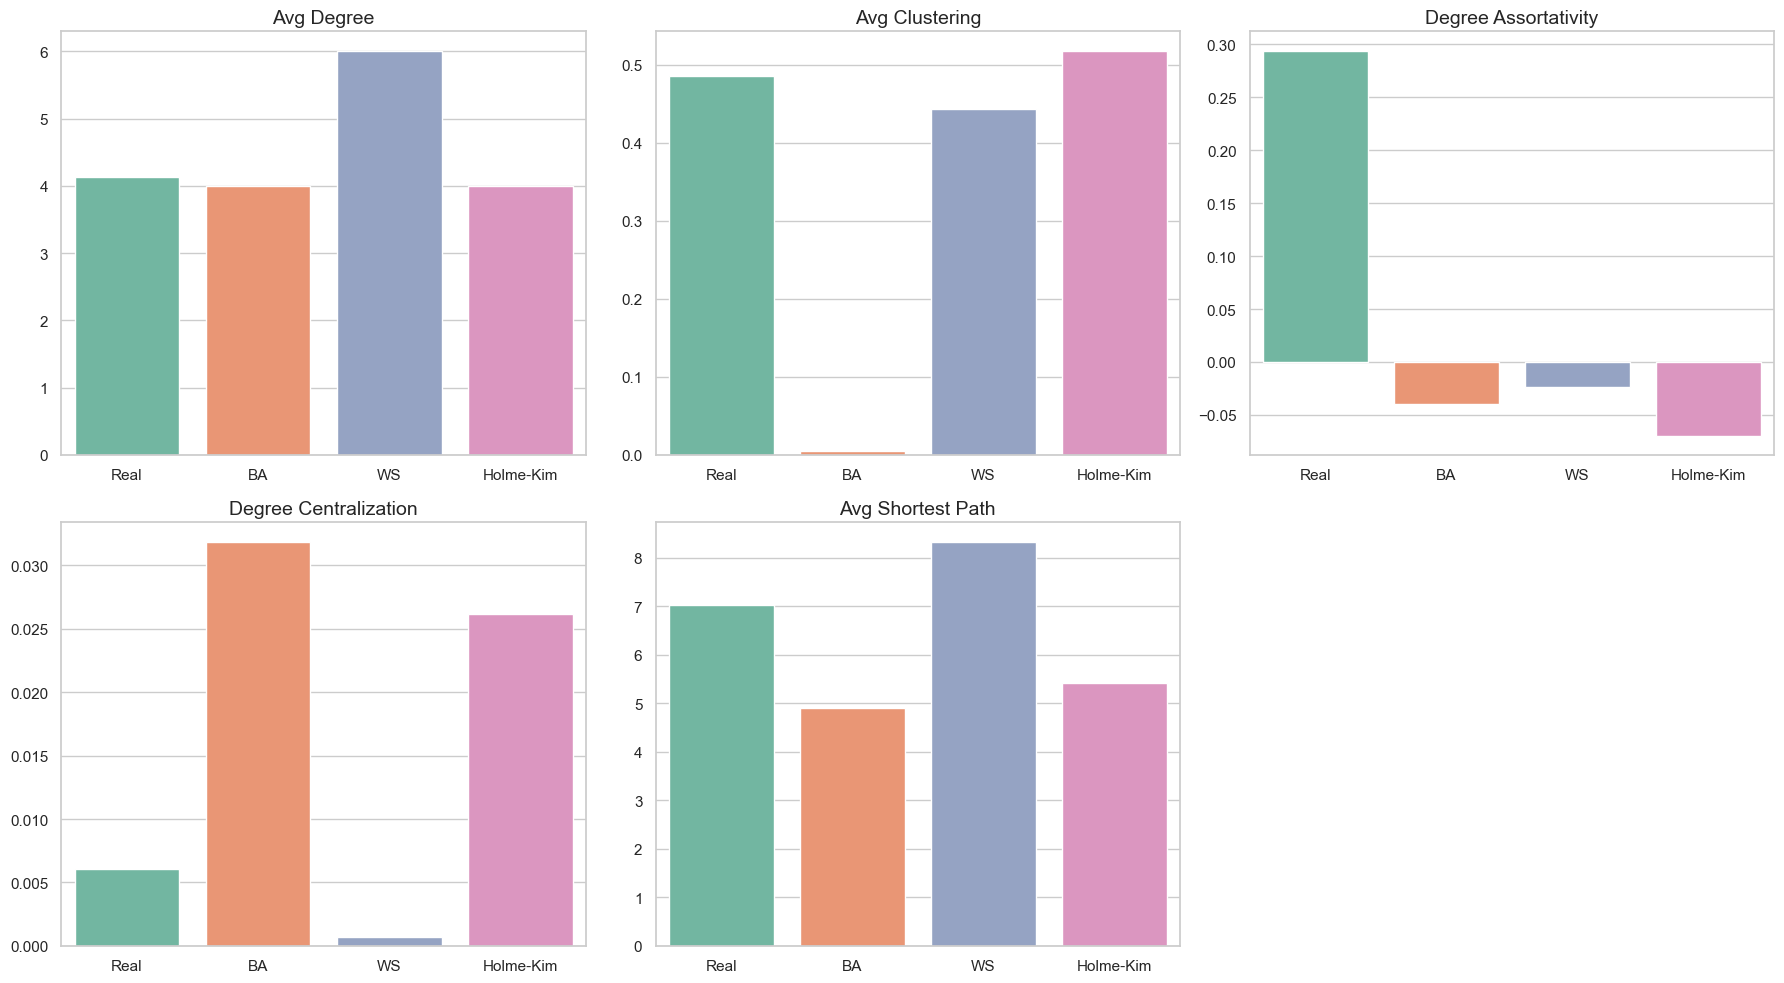

In [104]:
sns.set(style="whitegrid")
metrics = ["avg_degree", "avg_clustering", "degree_assortativity", "degree_centralization", "avg_shortest_path"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(x="network", y=metric, data=comparison_df, ax=axes[i], palette="Set2")
    axes[i].set_title(metric.replace("_", " ").title(), fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

if len(axes) > len(metrics):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [105]:
FILE_PATH = "data/wiki.txt"

In [107]:
G_wiki_dir = nx.DiGraph()

node_names = {}
with open(FILE_PATH, 'r') as f:
    for line in f:
        if line.startswith("#") or line.strip() == "":
            continue
        from_node, to_node = map(int, line.strip().split())
        node_names[int(from_node)] = f"node-{from_node}"
        node_names[int(to_node)] = f"node-{to_node}"
        G_wiki_dir.add_edge(from_node, to_node)

print(f"Nodes: {G_wiki_dir.number_of_nodes()}")
print(f"Edges: {G_wiki_dir.number_of_edges()}")

Nodes: 7115
Edges: 103689


In [108]:
def basic_metrics_dir(G):
    in_deg = np.array([d for _, d in G.in_degree()])
    out_deg = np.array([d for _, d in G.out_degree()])
    return {
        "N": G.number_of_nodes(),
        "E": G.number_of_edges(),
        "avg_in_degree": in_deg.mean(),
        "avg_out_degree": out_deg.mean(),
        "in_degree_std": in_deg.std(),
        "out_degree_std": out_deg.std(),
        "max_in_degree": in_deg.max(),
        "max_out_degree": out_deg.max()
    }

def clustering_metrics_dir(G):
    clustering_vals = list(nx.clustering(G.to_undirected()).values())  # directed clustering در nx محدوده، این یه approximationه
    return {
        "avg_clustering": np.mean(clustering_vals),
        "clustering_std": np.std(clustering_vals)
    }

def component_metrics_dir(G):
    # برای directed، strongly connected components هم مهمه
    scc = list(nx.strongly_connected_components(G))
    sizes = [len(c) for c in scc]
    sizes.sort(reverse=True)
    return {
        "num_scc": len(scc),
        "largest_scc_ratio": sizes[0] / G.number_of_nodes(),
        "second_scc_ratio": sizes[1] / G.number_of_nodes() if len(sizes) > 1 else 0
    }

def path_metrics_dir(G):
    gcc = G.subgraph(max(nx.strongly_connected_components(G), key=len)).copy()
    return {
        "avg_shortest_path": nx.average_shortest_path_length(gcc),
        "diameter": nx.diameter(gcc)
    }

def assortativity_metrics_dir(G):
    return {
        "degree_assortativity_in_in": nx.degree_assortativity_coefficient(G, x="in", y="in"),
        "degree_assortativity_out_out": nx.degree_assortativity_coefficient(G, x="out", y="out"),
        "degree_assortativity_in_out": nx.degree_assortativity_coefficient(G, x="in", y="out")
    }

def macro_metrics_dir(G):
    metrics = {}
    metrics.update(basic_metrics_dir(G))
    metrics.update(clustering_metrics_dir(G))
    metrics.update(component_metrics_dir(G))
    metrics.update(path_metrics_dir(G))
    metrics.update(assortativity_metrics_dir(G))
    return metrics

real_wiki_metrics_dir = macro_metrics_dir(G_wiki_dir)
real_wiki_metrics_dir["network"] = "Wiki-Vote-Directed"

In [109]:
real_wiki_metrics_dir

{'N': 7115,
 'E': 103689,
 'avg_in_degree': 14.573295853829936,
 'avg_out_degree': 14.573295853829936,
 'in_degree_std': 31.72872658686329,
 'out_degree_std': 42.279115598262216,
 'max_in_degree': 457,
 'max_out_degree': 893,
 'avg_clustering': 0.1408978458930873,
 'clustering_std': 0.19943903588705217,
 'num_scc': 5816,
 'largest_scc_ratio': 0.18271257905832747,
 'second_scc_ratio': 0.000140548137737175,
 'avg_shortest_path': 2.8792828803221413,
 'diameter': 9,
 'degree_assortativity_in_in': 0.0050910065792614395,
 'degree_assortativity_out_out': -0.018909153225472288,
 'degree_assortativity_in_out': 0.007095795579867646,
 'network': 'Wiki-Vote-Directed'}

In [110]:
def score_model(real, model):
    keys = ["avg_in_degree","avg_out_degree","avg_clustering",
            "degree_assortativity_in_in","degree_assortativity_out_out","degree_assortativity_in_out",
            "avg_shortest_path"]
    score = 0
    for k in keys:
        score += abs(real[k]-model[k])/(abs(real[k])+1e-6)
    return score

real_metrics = macro_metrics_dir(G_wiki_dir)
real_metrics["network"] = "Wiki-Vote-Directed"

n = G_wiki_dir.number_of_nodes()

ba_results = []
for m in range(1, 11):
    G_ba = nx.barabasi_albert_graph(n, m, seed=42)
    G_ba_dir = G_ba.to_directed()
    metrics_ba = macro_metrics_dir(G_ba_dir)
    metrics_ba["m"] = m
    metrics_ba["score"] = score_model(real_metrics, metrics_ba)
    ba_results.append(metrics_ba)
best_ba = pd.DataFrame(ba_results).loc[pd.DataFrame(ba_results)["score"].idxmin()]
best_ba["network"] = "BA"

ws_results = []
for k in range(2, int(round((real_metrics["avg_in_degree"] + real_metrics["avg_out_degree"])/2)*2), 2):
    for beta in [0.05, 0.1, 0.2, 0.3]:
        G_ws = nx.watts_strogatz_graph(n, k, beta, seed=42)
        G_ws_dir = G_ws.to_directed()
        metrics_ws = macro_metrics_dir(G_ws_dir)
        metrics_ws["k"] = k
        metrics_ws["beta"] = beta
        metrics_ws["score"] = score_model(real_metrics, metrics_ws)
        ws_results.append(metrics_ws)
best_ws = pd.DataFrame(ws_results).loc[pd.DataFrame(ws_results)["score"].idxmin()]
best_ws["network"] = "WS"

hk_results = []
for m_hk in range(1, 11):
    for p_tri in [0.3, 0.5, 0.7]:
        G_hk = nx.powerlaw_cluster_graph(n, m_hk, p_tri, seed=42)
        G_hk_dir = G_hk.to_directed()
        metrics_hk = macro_metrics_dir(G_hk_dir)
        metrics_hk["m_hk"] = m_hk
        metrics_hk["p_tri"] = p_tri
        metrics_hk["score"] = score_model(real_metrics, metrics_hk)
        hk_results.append(metrics_hk)
best_hk = pd.DataFrame(hk_results).loc[pd.DataFrame(hk_results)["score"].idxmin()]
best_hk["network"] = "Holme-Kim"

comparison_df = pd.DataFrame([real_metrics, best_ba, best_ws, best_hk])
cols = ["network","N","E","avg_in_degree","avg_out_degree","avg_clustering",
        "degree_assortativity_in_in","degree_assortativity_out_out","degree_assortativity_in_out",
        "avg_shortest_path"]
comparison_df = comparison_df[cols]
comparison_df

,network,N,E,avg_in_degree,avg_out_degree,avg_clustering,degree_assortativity_in_in,degree_assortativity_out_out,degree_assortativity_in_out,avg_shortest_path
0,Wiki-Vote-Directed,7115.0,103689.0,14.573296,14.573296,0.140898,0.005091,-0.018909,0.007096,2.879283
1,BA,7115.0,142100.0,19.971890,19.971890,0.014441,-0.019977,-0.019977,-0.019977,2.978979
2,WS,7115.0,128070.0,18.000000,18.000000,0.246316,-0.011366,-0.011366,-0.011366,3.706862
3,Holme-Kim,7115.0,42662.0,5.996065,5.996065,0.163039,-0.047820,-0.047820,-0.047820,4.170351


In [114]:
real_metrics = macro_metrics_dir(G_wiki_dir)
real_metrics["network"] = "Wiki-Vote-Directed"

in_deg_seq = [d for _, d in G_wiki_dir.in_degree()]
out_deg_seq = [d for _, d in G_wiki_dir.out_degree()]

G_config = nx.directed_configuration_model(in_deg_seq, out_deg_seq, create_using=nx.DiGraph(), seed=42)
G_config = nx.DiGraph(G_config)  # تبدیل به شبکه ساده
G_config.remove_edges_from(nx.selfloop_edges(G_config))

config_metrics = macro_metrics_dir(G_config)
config_metrics["network"] = "Config-Model-Directed"

comparison_df = pd.DataFrame([real_metrics, config_metrics])
cols = ["network","N","E","avg_in_degree","avg_out_degree","avg_clustering",
        "degree_assortativity_in_in","degree_assortativity_out_out","degree_assortativity_in_out",
        "avg_shortest_path"]
comparison_df = comparison_df[cols]

print(comparison_df)


                 network     N       E  avg_in_degree  avg_out_degree  \
0     Wiki-Vote-Directed  7115  103689      14.573296       14.573296   
1  Config-Model-Directed  7115   98614      13.860014       13.860014   

   avg_clustering  degree_assortativity_in_in  degree_assortativity_out_out  \
0        0.140898                    0.005091                     -0.018909   
1        0.049633                   -0.014776                     -0.015558   

   degree_assortativity_in_out  avg_shortest_path  
0                     0.007096           2.879283  
1                    -0.006080           2.744810  


In [115]:
comparison_df

,network,N,E,avg_in_degree,avg_out_degree,avg_clustering,degree_assortativity_in_in,degree_assortativity_out_out,degree_assortativity_in_out,avg_shortest_path
0,Wiki-Vote-Directed,7115,103689,14.573296,14.573296,0.140898,0.005091,-0.018909,0.007096,2.879283
1,Config-Model-Directed,7115,98614,13.860014,13.860014,0.049633,-0.014776,-0.015558,-0.006080,2.744810
